In [ ]:
from petastorm import make_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew,pearsonr
from scipy.signal import periodogram
from scipy.integrate import simpson
from ecgdetectors import Detectors
import matplotlib.ticker as ticker
import pywt
from biosppy.signals import ecg 
from sklearn.metrics import confusion_matrix,precision_score
from matplotlib.widgets import TextBox, Button
import sys
from sklearn import metrics
import pandas as pd
import seaborn as sn
import os
import neurokit2 as nk
import biosppy
from numba import njit
sys.path.append(os.path.join(os.getcwd(), ".."))
from shared_utils import TSD_cal as TSD
from shared_utils import HurstExponent as Hurst
path_formatted_glasgow = "/workspaces/maitrise/data/20221006_physio_quality/set-a/dataParquet"
path_petastorm = f"file:///{path_formatted_glasgow}"
path_csv_ref_label = "/workspaces/maitrise/data/20221006_physio_quality/set-a/REFERENCE.csv"

In [ ]:
###Data organization : Training dataset and Testing dataset + Reference labels

with make_reader(path_petastorm) as reader:
    for sample in reader:
        data = sample
        break

ECG_lead = data.signal_names
fs = data.sampling_frequency
dico_ECG = {}
for i,j in zip(ECG_lead,range(12)):
    dico_ECG[i] = data.signal[:,j]
N = len(dico_ECG[ECG_lead[0]])
print(data)



In [ ]:
##Get true label
label_ref = pd.read_csv(path_csv_ref_label)
label_ref = label_ref.to_numpy()
Y = label_ref[:,1].copy()
Y_true = Y[Y.copy()!="unlabeled"]
X_true = label_ref[:,0].copy()
X_true = X_true[Y!="unlabeled"].astype(int)


In [ ]:
##Observation of one patients :

def plot_ECG_signal(signal,name,length= data.signal_length,fs = data.sampling_frequency):
     x = np.array(range(0,(len(signal))))
     x = x/fs    
     fig,ax = plt.subplots(nrows = 1,ncols = 2, figsize = (20,10))
     ax[0].plot(x,signal)
     ax[0].set_title(f"Full signal of Lead {name.decode('utf8')}")
     ax[0].grid()
     ax[1].plot(x,signal)
     ax[1].set_title(f"Close up signal of Lead {name.decode('utf8')}")
     ax[1].grid()
     if len(x) == data.signal_length:
          ax[1].set_xlim([0,3])
     else :
          ax[1].set_xlim([0,x[-1]])
     plt.show()

ECG_signal = data.signal
ECG_lead = data.signal_names
fs = data.sampling_frequency
status = data.noun_id
dico_ECG = {}

for i,j in zip(ECG_lead,range(12)):
     dico_ECG[i] = ECG_signal[:,j]
     print(dico_ECG[i].shape)
     plot_ECG_signal(dico_ECG[i],i)
     
     

In [ ]:
###Some utilitary functions : 


def get_time_axis(sign_length,fs):
    x = np.linspace(0,int(sign_length/fs),sign_length)
    return x

def SDR_Quality_lead(SDR_dict_lead,name_lead):
    SDR_good_quality = {}
    SDR_medium_quality = {}
    SDR_bad_quality = {}
    for i in name_lead:
        if (SDR_dict_lead[i][0]<0.5 or SDR_dict_lead[i][0]>0.8):
            SDR_bad_quality[i] = SDR_dict_lead[i]
        elif (SDR_dict_lead[i][0]<0.6 and SDR_dict_lead[i][0]>0.5) or (SDR_dict_lead[i][0]<0.8 and SDR_dict_lead[i][0]>0.7):
            SDR_medium_quality[i] = SDR_dict_lead[i]
        else : 
            SDR_good_quality[i] = SDR_dict_lead[i]
    return SDR_good_quality,SDR_medium_quality,SDR_bad_quality


def wPMF_Quality_lead(wPMF_dict_lead,name_lead):
    wPMF_good_quality = {}
    wPMF_medium_quality = {}
    wPMF_bad_quality = {}
    for i in name_lead:
        if (wPMF_dict_lead[i][0]<0.25 or wPMF_dict_lead[i][0]>0):
            wPMF_bad_quality[i] = wPMF_dict_lead[i]
        elif (wPMF_dict_lead[i][0]<0.5 and wPMF_dict_lead[i][0]>0.25):
            wPMF_medium_quality[i] = wPMF_dict_lead[i]
        elif (wPMF_dict_lead[i][0]>0.5): 
            wPMF_good_quality[i] = wPMF_dict_lead[i]
    return wPMF_good_quality,wPMF_medium_quality,wPMF_bad_quality

def TSD_Quality_lead(TSD_dict_lead,name_lead):
    TSD_good_quality = {}
    TSD_medium_quality = {}
    TSD_bad_quality = {}
    for i in name_lead:
        if (TSD_dict_lead[i][0]>1.40):
            TSD_bad_quality[i] = TSD_dict_lead[i]
        elif (TSD_dict_lead[i][0]<1.40 and TSD_dict_lead[i][0]>1.25):
            TSD_medium_quality[i] = TSD_dict_lead[i]
        elif (TSD_dict_lead[i][0]<1.25): 
            TSD_good_quality[i] = TSD_dict_lead[i]
    return TSD_good_quality,TSD_medium_quality,TSD_bad_quality

def SNR_Quality_lead(SNR_dict_lead,name_lead):
    SNR_good_quality = {}
    SNR_medium_quality = {}
    SNR_bad_quality = {}
    for i in name_lead:
        if (SNR_dict_lead[i][0]<0.5):
            SNR_bad_quality[i] = SNR_dict_lead[i]
        elif (SNR_dict_lead[i][0]>0.5 and SNR_dict_lead[i][0]<50):
            SNR_medium_quality[i] = SNR_dict_lead[i]
        elif (SNR_dict_lead[i][0]>50): 
            SNR_good_quality[i] = SNR_dict_lead[i]
    return SNR_good_quality,SNR_medium_quality,SNR_bad_quality

def Morph_Quality_lead(M_dict_lead,name_lead):
    M_good_quality = {}
    M_medium_quality = {}
    M_bad_quality = {}
    for i in name_lead:
        if (M_dict_lead[i][0]<0.4):
            M_bad_quality[i] = M_dict_lead[i]
        elif (M_dict_lead[i][0]>0.4 and M_dict_lead[i][0]<0.66):
            M_medium_quality[i] = M_dict_lead[i]
        elif (M_dict_lead[i][0]>=0.66): 
            M_good_quality[i] = M_dict_lead[i]
    return M_good_quality,M_medium_quality,M_bad_quality

def CrossCor_Quality_lead(M_dict_lead,name_lead):
    M_good_quality = {}
    M_medium_quality = {}
    M_bad_quality = {}
    for i in name_lead:
        if (M_dict_lead[i][0]<0.4):
            M_bad_quality[i] = M_dict_lead[i]
        elif (M_dict_lead[i][0]>0.4 and M_dict_lead[i][0]<0.66):
            M_medium_quality[i] = M_dict_lead[i]
        elif (M_dict_lead[i][0]>=0.66): 
            M_good_quality[i] = M_dict_lead[i]
    return M_good_quality,M_medium_quality,M_bad_quality

def flat_Quality_lead(M_dict_lead,name_lead):
    f_good_quality = {}
    f_medium_quality = {}
    f_bad_quality = {}
    for i in name_lead:
        if (M_dict_lead[i][0]<0.2):
            f_good_quality[i] = M_dict_lead[i]
        elif (M_dict_lead[i][0]>0.2 and M_dict_lead[i][0]<0.5):
            f_medium_quality[i] = M_dict_lead[i]
        elif (M_dict_lead[i][0]>0.5): 
            f_bad_quality[i] = M_dict_lead[i]
    return f_good_quality,f_medium_quality,f_bad_quality

def HR_quality_lead(HR_dict,name_lead):
    HR_good_quality = {}
    HR_pathological_lead = {}
    HR_bad_quality = {}
    for i in name_lead : 
        val_HR = np.mean(HR_dict[i][0])
        if (val_HR>24 and val_HR<=220):
            HR_good_quality[i] = HR_dict[i]
        elif (val_HR>220 and val_HR<450):
            HR_pathological_lead[i] = HR_dict[i]
        else : 
            HR_bad_quality[i] = HR_dict[i]
    return HR_good_quality,HR_pathological_lead,HR_bad_quality

def Hurst_Quality_lead(HurstD_dict_lead,name_lead):
    HurstD_good_quality = {}
    HurstD_medium_quality = {}
    HurstD_bad_quality = {}
    for i in name_lead:
        if (HurstD_dict_lead[i][0]>1.40):
            HurstD_bad_quality[i] = HurstD_dict_lead[i]
        elif (HurstD_dict_lead[i][0]<1.40 and HurstD_dict_lead[i][0]>1.25):
            HurstD_medium_quality[i] = HurstD_dict_lead[i]
        elif (HurstD_dict_lead[i][0]<1.25): 
            HurstD_good_quality[i] = HurstD_dict_lead[i]
    return HurstD_good_quality,HurstD_medium_quality,HurstD_bad_quality


def set_classification_status(func_name,index_score):
    if func_name == "SDR":
        return SDR_classification_status(index_score)
    elif func_name == "wPMF":
        return wPMF_classification_status(index_score)
    elif func_name == "TSD":
        return TSD_classification_status(index_score)
    elif func_name == "SNR":
        return SNR_classification_status(index_score)
    elif func_name == "HR":
        return HR_classification_status(index_score)
    elif func_name=="Hurst":
        return HurstD_classification_status(index_score)
    elif func_name=="Morph":
        return Morph_classification_status(index_score)
    elif func_name=="flat":
        return flat_classification_status(index_score)
    elif func_name == "CrossCor":
        return CrossCor_classification_status(index_score)

def set_quality_lead(func_name,funct_dict_lead,name_lead):
    if func_name == "SDR":
        return SDR_Quality_lead(funct_dict_lead,name_lead)
    elif func_name == "wPMF":
        return wPMF_Quality_lead(funct_dict_lead,name_lead)
    elif func_name == "TSD":
        return TSD_Quality_lead(funct_dict_lead,name_lead)
    elif func_name == "SNR":
        return SNR_Quality_lead(funct_dict_lead,name_lead)
    elif func_name == "HR":
        return HR_quality_lead(funct_dict_lead,name_lead)
    elif func_name == "Hurst":
        return Hurst_Quality_lead(funct_dict_lead,name_lead)
    elif func_name == "Morph":
        return Morph_Quality_lead(funct_dict_lead,name_lead)
    elif func_name=="flat":
        return flat_Quality_lead(funct_dict_lead,name_lead)
    elif func_name=="CrossCor":
        return CrossCor_Quality_lead(funct_dict_lead,name_lead)


def flat_classification_status(index_score):
    if index_score<0.7:
        return "acceptable"
    else : 
        return "unacceptable"

def wPMF_classification_status(mean_wPMF):
    if (mean_wPMF>0.11):
        return "acceptable"
    else : 
        return "unacceptable"

def SDR_classification_status(mean_SDR):
    if (mean_SDR>0.5 and mean_SDR<0.8):
        return "acceptable"
    else : 
        return "unacceptable"

def TSD_classification_status(mean_TSD):
    if (mean_TSD<1.56):
        return "acceptable"
    else : 
        return "unacceptable"

def HurstD_classification_status(mean_HurstD):
    if (mean_HurstD<1.5):
        return "acceptable"
    else : 
        return "unacceptable"

def SNR_classification_status(mean_SNR):
    if mean_SNR>0.5:
        return "acceptable"
    else : 
        return "unacceptable"

def Morph_classification_status(mean_M):
    if mean_M>=0.50:
        return "acceptable"
    else : 
        return "unacceptable"

def HR_classification_status(mean_HR):
    if mean_HR>24 and mean_HR<450:
        return "acceptable"
    else : 
        return "unacceptable"

def CrossCor_classification_status(mean_CC):
    if mean_CC>=0.4:
        return "acceptable"
    else : 
        return "unacceptable"

def Sorter_X_array(X_arr):
    index_sorted = np.argsort(X_arr)
    X_arr_sort = np.sort(X_arr)
    return X_arr_sort,index_sorted

In [ ]:
###Morphological QRS complex (by QRS complex, it is all the PQRST wave)
####Rule : if average Pearson correlation,between the matching template and each beats detected, >0.66 => Acceptable. Else : Unacceptable



def is_segment_flatline(sig):
    cond = np.where(np.diff(sig.copy())!=0.0,np.nan,True)
    if (len(cond[cond==True])<0.50*len(sig)):
        return False
    else : 
        return True

def PQRST_template_extractor(ECG_signal,rpeaks):
    ##From the Biosspy function _extract_heartbeats
    R = np.sort(rpeaks)
    length = len(ECG_signal)
    templates = []
    newR = []

    for r in R:
        a = r-(np.median(np.diff(rpeaks,1))/2)
        if a < 0:
            continue
        b = r+(np.median(np.diff(rpeaks,1))/2)
        if b > length:
            break
            
        templates.append(ECG_signal[int(a):int(b)])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype="int")

    return templates, newR



def Morph_score(signals,name_lead,fs):
    QRS_lead = {}
    QRS_templates = {}
    QRS_arr = np.array([])
    detect = Detectors(fs)
    for i in name_lead:
        r_peaks = detect.pan_tompkins_detector(signals[i])
        if is_segment_flatline(signals[i]) or len(r_peaks)<=2:
            QRS_lead[i] = (0,signals[i])
            QRS_arr = np.append(QRS_arr,0)
            continue
        else :
           
            template,_ =PQRST_template_extractor(signals[i],rpeaks = r_peaks)
            empty_index = np.array([],dtype = int)
            for ble in range(template.shape[0]):
                if template[ble].size==0:
                    empty_index = np.append(empty_index,ble)
            template = np.delete(template,empty_index,0)
            index_maxima = [np.argmax(template[w].copy()) for w in range(template.shape[0])]
            median_index = np.median(index_maxima.copy())
            templates_good = template[np.isclose(index_maxima.copy(),median_index,rtol=0.1)].copy()
            if templates_good.shape[0] == 0:
                QRS_lead[i] = (0,signals[i])
                QRS_arr = np.append(QRS_arr,0)
                continue
            
            sig_mean = templates_good[0].copy()
            for j in range(1,templates_good.shape[0]):
                if sig_mean.size != templates_good[j].size:
                    templates_good[j] = templates_good[j][:len(sig_mean)]
                sig_mean = np.add(sig_mean,templates_good[j].copy())
            
            sig = sig_mean/templates_good.shape[0]
            r_p = np.array([])
            for w in range(templates_good.shape[0]):
                beats = templates_good[w,:].copy()
                r_p = np.append(r_p,pearsonr(sig,beats)[0])
            QRS_lead[i] = (np.mean(r_p.copy()),signals[i])
            QRS_arr = np.append(QRS_arr,np.mean(r_p.copy()))
    return QRS_lead,np.mean(QRS_arr)



In [ ]:
###Index Creation : SDR 
### The label will be as follow : 0.8>mean(SDR of all lead) > 0.5 = Acceptable;mean(SDR of all lead) <0.5 or >0.8 = Unacceptable
##For each lead, we will return a mor eprecise classification based on the folloying rules
## SDR<0.5 or SDR>0.8 = Bad quality ; 0.6>SDR>0.5 or 0.8>SDR>0.7= Medium quality; 0.7>SDR>0.6 = Good quality

def SDR_score(signals,name_lead,fs):
    ##SDR coeff:
    SDR_lead = {}
    SDR_arr = np.array([])
    for i in name_lead:
        f,PSD = periodogram(signals[i],fs)
        QRS_signal_PSD = np.sum(PSD[np.logical_and(f>=5,f<=14)])
        ECG_tot = np.sum(PSD[np.logical_and(f>=5,f<=50)],dtype = np.float64)
        if ECG_tot == 0:
            ECG_tot = np.sum(np.abs(signals[i])**2)
            if ECG_tot ==0:
                ECG_tot = 2**63-1
        SDR_val = QRS_signal_PSD/ECG_tot
        SDR_lead[i] = (SDR_val,signals[i])
        SDR_arr = np.append(SDR_arr,SDR_val)
    return SDR_lead,np.mean(SDR_arr)



In [ ]:
###Index Creation : wPMF
### The label will be as follow : mean(SDR of all lead) > 0.5 = Acceptable;mean(SDR of all lead) <0.5 = Unacceptable
##For each lead, we will return a mor eprecise classification based on the folloying rule: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9281614/#B25



def Wavelet_coef(sig,name,lev):
    All_coeff = pywt.wavedec(sig,name,level = lev)

    CA = All_coeff[0]
    CD = All_coeff[1:len(All_coeff)]
    return CA,CD  


def Energy_L2(coeff):
    return np.sum(np.abs(coeff)**2, dtype = np.float64)

def wPMF_score(dico_signal,name_lead,fs):
    waveletname = 'db4'
    level_w = 9
    wPMF_lead = {}
    wPMF_arr = np.array([],dtype = np.float64)
    for i in name_lead:
        CA_w,CD_w = Wavelet_coef(dico_signal[i],waveletname,level_w)
        CD_w = np.array(CD_w,dtype = object)
        CA_w = np.array(CA_w,dtype = object)
        E = np.array([])
        for CD in range(level_w):
            E = np.append(E,Energy_L2(CD_w[-(CD+1)]))
        E = np.append(E,Energy_L2(CA_w[0]))
        Etot = np.sum(E,dtype = np.float64)
        if Etot == 0:
            Etot = Energy_L2(dico_signal[i][:int((2**level_w)-1)])
            if Etot ==0:
                Etot = 2**63-1
        p = E/Etot
        SQI_ECG = np.sum(p[3:6])
        wPMF_lead[i] = (SQI_ECG,dico_signal[i])
        wPMF_arr = np.append(wPMF_arr,SQI_ECG)
    return wPMF_lead, np.mean(wPMF_arr, dtype = np.float64)

In [ ]:
###Index Creation : SNR
### The label will be as follow : mean(SNR of all lead) > 0.5 = Acceptable;mean(SNR of all lead) <0.5 = Unacceptable
##For each lead, we will return a more eprecise classification based on the folloying rules
## SNR<0.5  = Bad quality ; 0.5>SNR<10= Medium quality; SNR>10 = Good quality

def SNR_index(dico_signal,name_lead,fs):
    SNR_lead = {}
    SNR_arr = np.array([],dtype = np.float64)
    for i in name_lead:
        f,PSD = periodogram(dico_signal[i],fs)
        Sig_PSD = np.sum(PSD[np.logical_and(f>2,f<=40)])
        LF_PSD = np.sum(PSD[np.logical_and(f>=0,f<=2)])
        HF_PSD = np.sum(PSD[np.logical_and(f>40,f<=250)])
        if (LF_PSD+HF_PSD == 0.0):
            SNR = Sig_PSD/(LF_PSD+HF_PSD+0.0001)
        else:
            SNR = Sig_PSD/(LF_PSD+HF_PSD)
        SNR_db = 10*np.log10(SNR)
        SNR_lead[i] = (SNR_db,dico_signal[i])
        SNR_arr = np.append(SNR_arr,SNR_db)
    return SNR_lead,np.mean(SNR_arr)
        


In [ ]:
##Def flatline score
### The label will be as follow : mean(len(segment flatline)) > 0.5 * len(signal) = unacceptable;Else : Acceptable
# For each lead, we will return a more eprecise classification based on the folloying rules
## len(segment flatline)<0.2*len(signal)  = Excellent quality ; len(segment flatline)<0.5*len(signal)= Medium quality; len(segment flatline)>0.5*len(signal) = BAD quality

def flatline_score(dico_signals,name_lead,fs):
    flat_lead = {}
    flat_arr = np.array([],dtype = np.float64)
    for i in name_lead:
        cond = np.where(np.diff(dico_signals[i].copy())!=0.0,np.nan,True)
        score = len(cond[cond==True])/len(dico_signals[i])
        flat_lead[i] = (score,dico_signals[i])
        flat_arr = np.append(flat_arr,score)
    return flat_lead,np.mean(flat_arr)

In [ ]:
### Trial index Corr coeff between each Lead : 

def Corr_lead_score(dico_signal,name_lead,fs):
    # dico_template = {}
    dico_results = {}
    # copy_name = name_lead.copy()
    # for i in name_lead:
    #     QRS_template = Mean_template_extractor(dico_signal[i],fs)
    #     if QRS_template.size ==0:
    #         dico_results[i] = (0,dico_signal[i])
    #         copy_name = copy_name[copy_name!=i]
    #         continue
    #     dico_template[i] = QRS_template
    copy_name = name_lead.copy()
    X = np.empty([len(copy_name),len(dico_signal[copy_name[0]])])
    for i in range(len(copy_name)):
        X[i,:] = dico_signal[copy_name[i]]
    M = np.corrcoef(X)
    if M.size == 1:
        dico_results[name_lead[0]] = (1,dico_signal[name_lead[0]])
        return dico_results,1/12
    M_arr = np.array([])
    for j in range(len(copy_name)):
        val = (np.mean(np.abs(M[j,:])))
        dico_results[copy_name[j]] = (val,dico_signal[copy_name[j]])
        M_arr = np.append(M_arr,val)
    return dico_results,np.mean(M_arr)

In [ ]:
dico_SQI = {"SDR":SDR_score,"wPMF":wPMF_score,"TSD":TSD.TSD_index,"SNR":SNR_index,"Hurst":Hurst.HurstD_index}

In [ ]:
##The general function to run statistical test : 

def Runner_statistic(func,name_func,path_peta,y_true,y):
    matrix = {}
    matrix["Y_True"] = y_true

    ##Dictionary lead quality for each patient with SDR
    lead_patient_history_func = {}

    Big_dataset = np.array([])
    Lead_dataset_score = np.empty([1000,12])
    X_predicted = np.array([])
    Y_predicted = np.array([])
    func_val_index = np.array([])
    ind = 0
    with make_reader(path_peta) as reader:
        for sample in reader:
            data = sample
            X_predicted = np.append(X_predicted,int(data.noun_id))
            ECG_lead = data.signal_names
            fs = data.sampling_frequency
            status = data.noun_id
        
            dico_ECG = {}

            for i,j in zip(ECG_lead,range(12)):
                dico_ECG[i] = data.signal[:,j]
                
            func_lead,func_index= func(dico_ECG,ECG_lead,fs)

            Big_dataset = np.append(Big_dataset,func_index)
            func_val_index = np.append(func_val_index,func_index)
            lead_good,lead_medium,lead_bad = set_quality_lead(name_func,func_lead,ECG_lead)
            lead_patient_history_func[status] = np.array([lead_good,lead_medium,lead_bad])
            
            varr  = np.array([func_lead[j][0] for j in ECG_lead])
            Lead_dataset_score[ind,:] = varr
            ind+=1
        
      
    for val in Big_dataset:
        prediction = set_classification_status(name_func,val)
        Y_predicted = np.append(Y_predicted,prediction)
    
    X_pred_sorted,ind_sort = Sorter_X_array(X_predicted)
    Y_predicted = Y_predicted[ind_sort]
    func_val_index = func_val_index[ind_sort]
    Y_predicted = Y_predicted[y!="unlabeled"]
    func_val_index = func_val_index[y!="unlabeled"]
    matrix["Y_predict"] = Y_predicted
    cm = confusion_matrix(y_true, Y_predicted).ravel()
    if len(cm)>4:
        tp,fn,fp,tn = cm[cm!=0]
    else :
        tp,fn,fp,tn = cm
    print("TP = ",tp)
    print("TN = ",tn)
    print("FP = ",fp)
    print("FN =",fn)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    Prec = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1 = (2*Recall*Prec)/(Recall+Prec)
    print("Accuracy = ",Acc)
    print("Precision = ",Prec)
    print("Recall = ",Recall)
    print("F1 score = ",F1)

    ##Confusion matrix :
    df = pd.DataFrame(matrix, columns=['Y_True','Y_predict'])
    confusion = pd.crosstab(df['Y_True'], df['Y_predict'], rownames=['Actual'], colnames=['Predicted'],margins = True)
    sn.heatmap(confusion, annot=True,fmt='g')
    plt.title(f"Confusion Matrix for using the {name_func} index")
    plt.show()

    return Y_predicted,func_val_index,lead_patient_history_func,Lead_dataset_score,X_predicted

In [ ]:
##Test index SDR
Y_pred_SDR,SDR_val_index,lead_patients_history_SDR,Lead_dataset_SDR,X_SDR = Runner_statistic(SDR_score,"SDR",path_petastorm,Y_true,Y)

In [ ]:
##Test index Moprhological
Y_pred_M,M_val_index,lead_patients_history_M,Lead_dataset_M,X_M = Runner_statistic(Morph_score,"Morph",path_petastorm,Y_true,Y)

In [ ]:
##Test index CrossCor
Y_pred_CC,CC_val_index,lead_patients_history_CC,Lead_dataset_CC,X_CC = Runner_statistic(Corr_lead_score,"CrossCor",path_petastorm,Y_true,Y)

In [ ]:
#Test index Flatline : 
Y_pred_f,f_val_index,lead_patients_history_f,Lead_dataset_f,X_f = Runner_statistic(flatline_score,"flat",path_petastorm,Y_true,Y)

In [ ]:
###Test index wPMF

Y_pred_wPMF,wPMF_val_index,lead_patients_history_wPMF,Lead_dataset_wPMF,X_wPMF =Runner_statistic(wPMF_score,"wPMF",path_petastorm,Y_true,Y)

In [ ]:
##Test index Hurst
Y_pred_HD,HD_val_index,lead_patients_history_HD,Lead_dataset_HD,X_HD = Runner_statistic(Hurst.HurstD_index,"Hurst",path_petastorm,Y_true,Y)

In [ ]:
###Test index TSD
Y_pred_TSD,TSD_val_index,lead_patients_history_TSD,Lead_dataset_TSD,X_TSD =Runner_statistic(TSD.TSD_index_solo,"TSD",path_petastorm,Y_true,Y)

In [ ]:
###Get histogram of optimal segment length for both acceptable and unacceptable lead:

c_acceptable = np.array([])
c_unacceptable = np.array([])

with make_reader(path_petastorm) as reader:
        for sample in reader:
            data = sample
            if data.signal_quality == "acceptable".encode():
                ECG_lead = data.signal_names
                ECG_signal = data.signal
                fs = data.sampling_frequency
                dico_ECG = {}

                for j in range(12):
                    c = TSD.Interval_calculator_lead(ECG_signal[:,j],fs)
                    c_acceptable = np.append(c_acceptable,c)
            elif data.signal_quality == "unacceptable".encode(): 
                ECG_lead = data.signal_names
                ECG_signal = data.signal
                fs = data.sampling_frequency
                dico_ECG = {}

                for j in range(12):
                    c = TSD.Interval_calculator_lead(ECG_signal[:,j],fs)
                    c_unacceptable = np.append(c_unacceptable,c)
            else : 
                break

print(c_unacceptable)
h_acc, bins_acc = np.histogram(c_acceptable)
h_unacc, bins_unacc = np.histogram(c_unacceptable)

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,15))
ax[0].hist(c_acceptable,bins = bins_acc)
ax[0].set_xlabel("Optimal segment")
ax[0].set_ylabel("Frequencies")
ax[0].set_title("Histogram of optimal segment legnth for all lead of acceptbale ECG")
ax[0].grid()
ax[1].hist(c_unacceptable,bins = bins_unacc)
ax[1].set_xlabel("Optimal segment")
ax[1].set_ylabel("Frequencies")
ax[1].set_title("Histogram of optimal segment length for all lead of unacceptbale ECG")
ax[1].grid()      

                

In [ ]:
##repartition max min val I1 I2 ECG :
I1_max_acc = np.array([])
I2_max_acc = np.array([])
I1_max_unacc = np.array([])
I2_max_unacc = np.array([])
I1_min_acc = np.array([])
I2_min_acc = np.array([])
I1_min_unacc = np.array([])
I2_min_unacc = np.array([])
with make_reader(path_petastorm) as reader:
        for sample in reader:
            data = sample
            if data.signal_quality == "acceptable".encode():
                ECG_lead = data.signal_names
                ECG_signal = data.signal
                fs = data.sampling_frequency
                dico_ECG = {}

                for j in range(12):
                    I1t,I2t,_ = TSD.discrepancies_mean_curve(data.signal[:,j],fs,0.001,0.005)
                    I1_max_acc = np.append(I1_max_acc,np.amax(I1t))
                    I1_min_acc = np.append(I1_min_acc,np.amin(I1t))
                    I2_max_acc = np.append(I2_max_acc,np.amax(I2t))
                    I2_min_acc = np.append(I2_min_acc,np.amin(I2t))
                    
            elif data.signal_quality == "unacceptable".encode(): 
                ECG_lead = data.signal_names
                ECG_signal = data.signal
                fs = data.sampling_frequency
                dico_ECG = {}

                for j in range(12):
                    I1t,I2t,_ = TSD.discrepancies_mean_curve(data.signal[:,j],fs,0.001,0.005)
                    I1_max_unacc = np.append(I1_max_acc,np.amax(I1t))
                    I1_min_unacc = np.append(I1_min_acc,np.amin(I1t))
                    I2_max_unacc = np.append(I2_max_acc,np.amax(I2t))
                    I2_min_unacc = np.append(I2_min_acc,np.amin(I2t))
                    
            else : 
                break

counts_I1max_acc, bins_I1max_acc = np.histogram(I1_max_acc)
counts_I1max_unacc, bins_I1max_unacc = np.histogram(I1_max_unacc)
counts_I2max_acc, bins_I2max_acc = np.histogram(I2_max_acc)
counts_I2max_unacc, bins_I2max_unacc = np.histogram(I2_max_unacc)
counts_I2min_acc, bins_I2min_acc = np.histogram(I2_min_acc)
counts_I2min_unacc, bins_I2min_unacc = np.histogram(I2_min_unacc)
counts_I1min_acc, bins_I1min_acc = np.histogram(I1_min_acc)
counts_I1min_unacc, bins_I1min_unacc = np.histogram(I1_min_unacc)
fig,ax = plt.subplots(nrows = 4, ncols = 2,figsize = (20,15), constrained_layout=True)
fig.tight_layout(h_pad=5)
ax[0,0].hist(bins_I1max_acc[:-1],bins_I1max_acc,weights = counts_I1max_acc,edgecolor='black')
ax[0,0].set_xlabel("I1(c) Max value")
ax[0,0].set_ylabel("Frequencies")
ax[0,0].set_title("Histogram of maximum value of I1 for all lead of acceptbale ECG")
ax[0,0].grid()
ax[0,1].hist(bins_I1max_unacc[:-1],bins_I1max_unacc,weights = counts_I1max_unacc,edgecolor='black')
ax[0,1].set_xlabel("I1(c) Max value")
ax[0,1].set_ylabel("Frequencies")
ax[0,1].set_title("Histogram of maximum value of I1 for all lead of unacceptbale ECG")
ax[0,1].grid()
ax[1,0].hist(bins_I1min_acc[:-1],bins_I1min_acc,weights = counts_I1min_acc,edgecolor='black')
ax[1,0].set_ylabel("Frequencies")
ax[1,0].set_title("Histogram of minimum value of I1 for all lead of acceptbale ECG")
ax[1,0].grid()
ax[1,1].hist(bins_I1min_unacc[:-1],bins_I1min_unacc,weights = counts_I1min_unacc,edgecolor='black')
ax[1,1].set_xlabel("I1(c) Min value")
ax[1,1].set_ylabel("Frequencies")
ax[1,1].set_title("Histogram of minimum value of I1 for all lead of unacceptbale ECG")
ax[1,1].grid()
ax[2,0].hist(bins_I2max_acc[:-1],bins_I2max_acc,weights = counts_I2max_acc,edgecolor='black')
ax[2,0].set_xlabel("I2(c) Max value")
ax[2,0].set_ylabel("Frequencies")
ax[2,0].set_title("Histogram of maximum value of I2 for all lead of acceptbale ECG")
ax[2,0].grid()
ax[2,1].hist(bins_I2max_unacc[:-1],bins_I2max_unacc,weights = counts_I2max_unacc,edgecolor='black')
ax[2,1].set_xlabel("I2(c) Max value")
ax[2,1].set_ylabel("Frequencies")
ax[2,1].set_title("Histogram of maximum value of I2 for all lead of unacceptbale ECG")
ax[2,1].grid()
ax[3,0].hist(bins_I2min_acc[:-1],bins_I2min_acc,weights = counts_I2min_acc,edgecolor='black')
ax[3,0].set_xlabel("I2(c) Min value")
ax[3,0].set_ylabel("Frequencies")
ax[3,0].set_title("Histogram of minimum value of I2 for all lead of acceptbale ECG")
ax[3,0].grid()
ax[3,1].hist(bins_I2min_unacc[:-1],bins_I2min_unacc,weights = counts_I2min_unacc,edgecolor='black')
ax[3,1].set_xlabel("I2(c) Min value")
ax[3,1].set_ylabel("Frequencies")
ax[3,1].set_title("Histogram of minimum value of I2 for all lead of unacceptbale ECG")
ax[3,1].grid()
fig.subplots_adjust(top=0.90)        

In [ ]:
##Test index SNR

Y_pred_SNR,SNR_val_index,lead_patients_history_SNR,Lead_dataset_SNR,X_SNR =Runner_statistic(SNR_index,"SNR",path_petastorm,Y_true,Y)

In [ ]:
###Trail 2D dimensions plot : Check if combining 2 index can separate well signal quality assessment

def The_2D_plot_creator(Y1,Y2,correct_label,name_1,name_2,name_label_used = "Original",semilog = False):
    plt.figure()

    for lab,c in zip(["acceptable","unacceptable"],["r","b"]):
        Y1_sel = Y1[correct_label == lab].copy()
        Y2_sel = Y2[correct_label == lab].copy()
        plt.scatter(Y1_sel,Y2_sel,color = c,label = lab,alpha = 0.3)
    plt.legend(["acceptable","unacceptable"])
    plt.grid()
    plt.xlabel(name_1)
    plt.ylabel(name_2)
    if semilog : 
        plt.semilogy()
    plt.title(f"{name_1} VS {name_2} with the {name_label_used} labelisation" )
    plt.show()

###Let's plot!

# The_2D_plot_creator(SDR_val_index,wPMF_val_index,Y_true,"SDR","wPMF")
# The_2D_plot_creator(M_val_index,TSD_val_index,Y_true,"Morphological","TSD")
# The_2D_plot_creator(wPMF_val_index,HD_val_index,Y_true,"wPMF","Hurst Fractal D")
# The_2D_plot_creator(wPMF_val_index,SNR_val_index,Y_true,"wPMF","SNR")
# The_2D_plot_creator(SDR_val_index,SNR_val_index,Y_true,"SDR","SNR")
The_2D_plot_creator(TSD_val_index,wPMF_val_index,Y_true,"TSD","wPMF")

#The_2D_plot_creator(TSD_val_index,SNR_val_index,Y_true,"TSD","SNR",semilog =True)


In [ ]:
from mpl_toolkits import mplot3d
%matplotlib widget
def The_3D_plot_creator(Y1,Y2,Y3,correct_label,name_1,name_2,name_3,name_label_used = "Original",semilog = False):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for lab,col in zip(["acceptable","unacceptable"],["r","b"]):
        Y1_sel = Y1[correct_label == lab].copy()
        Y2_sel = Y2[correct_label == lab].copy()
        Y3_sel = Y3[correct_label == lab].copy()
        ax.scatter3D(Y1_sel,Y2_sel,Y3_sel,color = col,label = lab,alpha = 0.3)
    ax.legend(["acceptable","unacceptable"])
    ax.grid()
    ax.set_xlabel(name_1)
    ax.set_ylabel(name_2)
    ax.set_zlabel(name_3)

    if semilog : 
        plt.semilogy()
    plt.title(f"{name_1} VS {name_2} VS {name_3} with the {name_label_used} labelisation" )
    plt.show()


In [ ]:
The_3D_plot_creator(TSD_val_index,M_val_index,wPMF_val_index,Y_true,"TSD","Morphological","wPMF")

In [ ]:
###Implementation HeartBeat detector ==> First Step of most SQA method in the litterature
###Goal of this method : Get the RR interval of each metho and check if BPM are in physiological range
### If pathological range ==> acceptable but with a the following message : "Suspicion of pathologie ==> Type of pathology"

###Frequency range considered:
### 24<f<300 : Acceptable (can be pathological but not so sure! need classification for that)
### 300<f<450 : Acceptbable but pathological (BPM with high risk of Fibrillation with multiple focal discharge)
### f>450 or f<24 : Unacceptable

def HR_index_calculator(dico_signal,name_lead,fs):
    RR_intervals_signal = {}
    mean_RR_interval = np.array([])
    x = get_time_axis(len(dico_signal[name_lead[0]]),fs)
    detect = Detectors(fs)
    for i in name_lead:
        r_peaks = detect.pan_tompkins_detector(dico_signal[i])
        r_sec = x[r_peaks]
        r_msec = r_sec*1000
        if len(r_msec) <=1:
            RR_intervals_signal[i] = (0.0,0.0)
            mean_RR_interval = np.append(mean_RR_interval,0.0)
        else:
            RR_bpm_interval = (60/(np.diff(r_msec)))*1000
            RR_intervals_signal[i] = (np.mean(RR_bpm_interval),dico_signal[i])
            mean_RR_interval = np.append(mean_RR_interval,np.mean(RR_bpm_interval))
        #RR_intervals_signal[i] = (np.diff(r_sec)*1000,r_peaks,np.mean(r_sec))
        #mean_RR_interval = np.append(mean_RR_interval,np.mean(r_sec))
    return RR_intervals_signal,np.mean(mean_RR_interval)




In [ ]:
###Test HR classifiction : 
Y_pred_HR,HR_val_index,lead_patients_history_HR,Lead_dataset_HR,X_HR=Runner_statistic(HR_index_calculator,"HR",path_petastorm,Y_true,Y)

In [ ]:
###Bad prediction presentation : Seeing what went wrong with each method

def Derprinterlead(dict_quality,t,prediction,act,quality,patient_ind):
    for i in dict_quality : 
        if type(dict_quality[i][0]) == np.ndarray:
            val = np.mean(dict_quality[i][0])
            plt.figure() 
            plt.plot(t,dict_quality[i][1].copy())
            plt.title(f"Full signal of Lead {i.decode('utf8')} for patient {patient_ind}")
            plt.grid()
            plt.xlim([0,3])
            plt.figtext(1, 0.7, "HR value = {0:.2f}".format(val))
            plt.figtext( 1, 0.6, "Label assigned = {0:.2f}".format(prediction))
            plt.figtext( 1, 0.5, "Quality = {0:.2f}".format(quality))
        else : 
            plt.figure() 
            plt.plot(t,dict_quality[i][1].copy())
            plt.title(f"Full signal of Lead {i.decode('utf8')} for patient {patient_ind}")
            plt.grid()
            plt.xlim([0,3])
            plt.figtext(1, 0.7, "Index value = {0:.2f}".format(dict_quality[i][0]))
            plt.figtext(1, 0.6, f"Label assigned = {prediction}")
            plt.figtext(1, 0.5, f"True label = {act}")
            plt.figtext(1, 0.4, "Quality = {}".format(quality))



def bad_prediction_case(pred,actual,X_actual,history_lead_patient,name_lead = ECG_lead[0]):
    index_bad = (actual!=pred)
    patients_concerned = X_actual[index_bad]
    i = patients_concerned[1]
    string = str(i)
    good_quality,medium_quality,bad_quality = history_lead_patient[string.encode()]
    N = 5000
    t = get_time_axis(N,fs)
    Derprinterlead(good_quality,t,pred[np.where(X_actual==i)],actual[np.where(X_actual==i)],"good",i)
    Derprinterlead(medium_quality,t,pred[np.where(X_actual==i)],actual[np.where(X_actual==i)],"medium",i)
    Derprinterlead(bad_quality,t,pred[np.where(X_actual==i)],actual[np.where(X_actual==i)],"bad",i)


    
    

In [ ]:
###Test Hurst:

bad_prediction_case(Y_pred_M,Y_true,X_true,lead_patients_history_M)


In [ ]:
##Time for some ROC (it's about DRIVE, it's about POWER, We stay angry, We DEVOUR......)


def wPMF_classification_status_ROC(mean_wPMF,thresh):
    if (mean_wPMF>thresh):
        return "acceptable"
    else : 
        return "unacceptable"

def flatline_classification_status_ROC(mean_f,thresh):
    if (mean_f<thresh):
        return "acceptable"
    else : 
        return "unacceptable"

def SDR_classification_status_ROC(mean_SDR,thresh):
    if (mean_SDR>thresh[0] and mean_SDR<thresh[1]):
        return "acceptable"
    else : 
        return "unacceptable"

def Morph_classification_status_ROC(mean_Morph,thresh):
    if mean_Morph>=thresh:
        return "acceptable"
    else : 
        return "unacceptable"

def TSD_classification_status_ROC(mean_TSD,thresh):
    if (mean_TSD<thresh):
        return "acceptable"
    else : 
        return "unacceptable"

def HurstD_classification_status_ROC(mean_HurstD,thresh):
    if (mean_HurstD<thresh):
        return "acceptable"
    else : 
        return "unacceptable"

def SNR_classification_status_ROC(mean_SNR,thresh):
    if mean_SNR>thresh:
        return "acceptable"
    else : 
        return "unacceptable"

def CrossCorr_classification_status_ROC(mean_CrossCor,thresh):
    if mean_CrossCor>thresh:
        return "acceptable"
    else : 
        return "unacceptable"

def set_classification_status_ROC(func_name,index_score,threshold):
    if func_name == "SDR":
        return SDR_classification_status_ROC(index_score,threshold)
    elif func_name == "wPMF":
        return wPMF_classification_status_ROC(index_score,threshold)
    elif func_name == "TSD":
        return TSD_classification_status_ROC(index_score,threshold)
    elif func_name == "SNR":
        return SNR_classification_status_ROC(index_score,threshold)
    elif func_name == "Hurst":
        return HurstD_classification_status_ROC(index_score,threshold)
    elif func_name == "Morph":
        return Morph_classification_status_ROC(index_score,threshold)
    elif func_name == "flat":
        return flatline_classification_status_ROC(index_score,threshold)
    elif func_name == "CrossCor":
        return CrossCorr_classification_status_ROC(index_score,threshold)



def ROC_runner(func,name_func,path_peta,y_true,y,Threshold_tab,Lead_Dataset,X_score):
    TPR = np.array([])
    FPR = np.array([])
    REC = np.array([])
    PREC = np.array([])
    ACC = np.array([])
    X_pred_sorted,ind_sort = Sorter_X_array(X_score)
    for j in Threshold_tab:
        matrix = {}
        matrix["Y_True"] = y_true
        Y_predicted = np.array([])
        for arr in range(Lead_Dataset.shape[0]):
            prediction = set_classification_status_ROC(name_func,np.mean(Lead_Dataset[arr,:]),j)
            Y_predicted = np.append(Y_predicted,prediction)
        
        
        Y_predicted = Y_predicted[ind_sort]
        Y_predicted = Y_predicted[y!="unlabeled"]
        matrix["Y_predict"] = Y_predicted
        cm = confusion_matrix(y_true, Y_predicted).ravel()
        if len(cm)>4:
            tp,fn,fp,tn = cm[cm!=0]
        else :
            tp,fn,fp,tn = cm
        
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        if tp+fp == 0:
            Prec = 0
        else : 
            Prec = tp/(tp+fp)
        Recall = tp/(tp+fn)
        acc = (tp+tn)/(tp+tn+fn+fp)
        ACC = np.append(ACC,acc)
        TPR = np.append(TPR,tpr)
        FPR = np.append(FPR,fpr)
        REC = np.append(REC,Recall)
        PREC = np.append(PREC,Prec)
    return TPR,FPR,REC,PREC,ACC

def ROC_plot(true_PR,False_PR,Threshold,index_tested,step):
    plt.figure()
    auc = np.abs(simpson(true_PR,x=False_PR,dx = 1/(len(False_PR))))
    opt_thresh = Threshold[np.argmin(np.sqrt((1-true_PR)**2+(False_PR)**2))]
    print(opt_thresh)
    plt.plot(False_PR,true_PR,label = "AUC = "+str(auc))

    # for t,i,j in zip(Threshold,False_PR,true_PR):
    #     plt.annotate("{0:.2f}".format(t),xy = (i,j))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for index {index_tested} ")
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def RP_plot(Recall,Prec,Threshold,index_tested,step):
    plt.figure()
    plt.plot(Recall,Prec)
    # for t,i,j in zip(Threshold,False_PR,true_PR):
    #     plt.annotate("{0:.2f}".format(t),xy = (i,j))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Recall vs Precision Curve for index {index_tested} ")
    plt.grid()
    plt.show()


def ACC_Threshod_plot(Acc,Threshold,index_tested):
    plt.figure()
    plt.plot(Threshold,Acc)
    # for t,i,j in zip(Threshold,False_PR,true_PR):
    #     plt.annotate("{0:.2f}".format(t),xy = (i,j))
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs Threshold Curve for index {index_tested} ")
    plt.grid()
    plt.show()
    print(Threshold[np.argmax(Acc)])



In [ ]:
##Test for TSD:
TSD_thresh = np.linspace(1,2,200)
TPR_TSD,FPR_TSD,REC_TSD,PREC_TSD,ACC_TSD = ROC_runner(TSD.TSD_index,"TSD",path_petastorm,Y_true,Y,TSD_thresh,Lead_dataset_TSD,X_TSD)
ROC_plot(TPR_TSD,FPR_TSD,TSD_thresh,"TSD",1/200)
RP_plot(REC_TSD,PREC_TSD,TSD_thresh,"TSD",1/200)
ACC_Threshod_plot(ACC_TSD,TSD_thresh,"TSD")

In [ ]:
##Test for Hurst:
TSD_thresh = np.linspace(1,2,200)
TPR_HD,FPR_HD,REC_HD,PREC_HD = ROC_runner(Hurst.HurstD_index,"Hurst",path_petastorm,Y_true,Y,TSD_thresh,Lead_dataset_HD,X_HD)
ROC_plot(TPR_HD,FPR_HD,TSD_thresh,"Hurst",1/200)
RP_plot(REC_HD,PREC_HD,TSD_thresh,"Hurst",1/200)

In [ ]:
##Test for Morphological:
M_thresh = np.linspace(0,1,200)
TPR_M,FPR_M,REC_M,PREC_M,ACC_M = ROC_runner(Morph_score,"Morph",path_petastorm,Y_true,Y,M_thresh,Lead_dataset_M,X_M)
ROC_plot(TPR_M,FPR_M,M_thresh,"Morph",1/400)
RP_plot(REC_M,PREC_M,M_thresh,"Morph",1/400)
ACC_Threshod_plot(ACC_M,M_thresh,"Morph")

In [ ]:
##Test for CrossCorr:
CC_thresh = np.linspace(0,1,200)
TPR_CC,FPR_CC,REC_CC,PREC_CC,ACC_CC = ROC_runner(Corr_lead_score,"CrossCor",path_petastorm,Y_true,Y,CC_thresh,Lead_dataset_CC,X_CC)
ROC_plot(TPR_CC,FPR_CC,CC_thresh,"CrossCor",1/200)
RP_plot(REC_CC,PREC_CC,CC_thresh,"CrossCor",1/200)
ACC_Threshod_plot(ACC_CC,CC_thresh,"CrossCor")

In [ ]:
##Test for wPMF:
wPMF_thresh = np.linspace(0,1,200)
TPR_wPMF,FPR_wPMF,REC_wPMF,PREC_wPMF,ACC_wPMF = ROC_runner(wPMF_score,"wPMF",path_petastorm,Y_true,Y,wPMF_thresh,Lead_dataset_wPMF,X_wPMF)
ROC_plot(TPR_wPMF,FPR_wPMF,wPMF_thresh,"wPMF",1/200)
RP_plot(REC_wPMF,PREC_wPMF,wPMF_thresh,"wPMF",1/200)
ACC_Threshod_plot(ACC_wPMF,wPMF_thresh,"wPMF")

In [ ]:
##Test for Flatline:
f_thresh = np.linspace(0,1,200)
TPR_f,FPR_f,REC_f,PREC_f,ACC_f = ROC_runner(flatline_score,"flat",path_petastorm,Y_true,Y,f_thresh,Lead_dataset_f,X_f)
ROC_plot(TPR_f,FPR_f,f_thresh,"flat",1/200)
RP_plot(REC_f,PREC_f,f_thresh,"flat",1/200)
ACC_Threshod_plot(ACC_f,f_thresh,"flat")

In [ ]:
##Test SNR 
SNR_thresh = np.linspace(-100,400,200)
TPR_SNR,FPR_SNR,REC_SNR,PREC_SNR,ACC_SNR = ROC_runner(SNR_index,"SNR",path_petastorm,Y_true,Y,SNR_thresh,Lead_dataset_SNR,X_SNR)
ROC_plot(TPR_SNR,FPR_SNR,SNR_thresh,"SNR",1/200)
RP_plot(REC_SNR,PREC_SNR,SNR_thresh,"SNR",1/200)
ACC_Threshod_plot(ACC_SNR ,SNR_thresh,"SNR")

In [31]:
###SQA Method trial : HR then SNR then wPMF + SDR (When TSD is working, We will place TSD)
##Matrix of Regularity : 
def flatline_score(signal):
    cond = np.where(np.diff(signal.copy())!=0.0,False,True)
    if (len(cond[cond==True])<0.50*len(signal)):
        return 0
    else : 
        return len(cond[cond==True])/len(signal)


def Flatline_matrix(dico_signal,name_lead):
    X = np.empty([12,len(dico_signal[name_lead[0]])])
    for f in range(len(name_lead)):
        X[f,:] = dico_signal[name_lead[f]].copy()
    
    F = np.zeros([len(name_lead),len(name_lead)])
    for j in range(len(name_lead)):
        p = flatline_score(X[j,:])
        if p!=0:
            F[j,j] += p
            if j!=len(name_lead)-1:
                F[j,j+1:] += p/11
                if j>0:
                    F[j,:j]+=p/11
    return F



def Missing_lead_score(dico_signal,name_lead):
    H_thres_ECG = 1
    L_thres_ECG = -1
    X = np.empty([12,len(dico_signal[name_lead[0]])])
    for j in range(len(name_lead)):
        X[j,:] = dico_signal[name_lead[j]].copy()

    F = np.zeros([len(name_lead),len(name_lead)])
    for e in range(len(name_lead)) :
        sig = X[e,:].copy()
        if H_thres_ECG-np.max(sig) >=0 and L_thres_ECG-np.min(sig)>0:
            p = np.abs((L_thres_ECG-np.min(sig))/np.min(sig))
        elif H_thres_ECG-np.max(sig) <0 and L_thres_ECG-np.min(sig)<=0:
            p = np.abs((H_thres_ECG-np.max(sig))/np.max(sig))
        elif H_thres_ECG-np.max(sig) <0 and L_thres_ECG-np.min(sig)>0:
            p = ((np.abs((H_thres_ECG-np.max(sig))/np.max(sig))+np.abs((L_thres_ECG-np.min(sig))/np.min(sig))))/2
            
        else : 
            p = 0
        
        F[e,e] += p
        if e!=len(name_lead)-1:
            F[e,e+1:] += p/11
        if e>0:
            F[e,:e]+=p/11


    return F


def overlap_percentage(xlist,ylist):
    min1 = np.min(xlist)
    max1 = np.max(xlist)
    min2 = np.min(ylist)
    max2 = np.max(ylist)
    overlap = np.maximum(0, np.minimum(max1, max2) - np.maximum(min1, min2))
    if overlap == 0.0:
        return 0,0,0
    else : 
        length = max1-min1 + max2-min2
        lengthx = max1-min1
        lengthy = max2-min2
        return 2*overlap/length , overlap/lengthx  , overlap/lengthy 

def overlapping_sig(dico_signal,name_lead):

    X = np.empty([12,len(dico_signal[name_lead[0]])])

    s = 5

    for j in range(len(name_lead)):
        X[j,:] = dico_signal[name_lead[j]].copy()+s*j
    
    ALL_THE_OVERLAP_OF_NIGHTMARE = np.zeros([len(name_lead),len(name_lead)])
    for j in range(len(name_lead)):
        sig = X[j,:]
        list_travel = list(range(len(name_lead)))
        list_travel.remove(j)
        for i in list_travel:
            p,_,_ = overlap_percentage(sig,X[i,:])
            if p!=0:
                ALL_THE_OVERLAP_OF_NIGHTMARE[j,i] += p
                

    return ALL_THE_OVERLAP_OF_NIGHTMARE


def SDR_matrix(dico_signal,name_lead,fs):
    
    X = np.empty([12,len(dico_signal[name_lead[0]])])
    for f in range(len(name_lead)):
        X[f,:] = dico_signal[name_lead[f]].copy()
    S = np.zeros([12,12])
    for j in range(X.shape[0]):
        f,PSD = periodogram(X[j,:],fs)
        QRS_signal_PSD = np.sum(PSD[np.logical_and(f>=5,f<=14)])
        ECG_tot = np.sum(PSD[np.logical_and(f>=5,f<=50)],dtype = np.float64)
        if ECG_tot == 0:
            ECG_tot = np.sum(np.abs(X[j,:])**2)
            if ECG_tot ==0:
                ECG_tot = 2**63-1
        SDR_val = QRS_signal_PSD/ECG_tot
        rho = max([0.5-SDR_val,SDR_val-0.8,0])
        S[j,j] += rho
        list_travel = list(range(len(name_lead)))
        list_travel.remove(j)
        for i in list_travel:
            S[j,i] += rho/11
    return S

def Global_score(SM,FM,OM,SDM,arr=np.array([0.3,0.8,0.1,1])):
    M = arr[0]*SM+arr[1]*FM+arr[2]*OM+arr[3]*SDM
    results = np.array([])
    for i in range(M.shape[0]):
        results = np.append(results,np.sum(M[:,i]))
    SR = np.max(np.abs(np.linalg.eigvals(M)))
    return results,SR

def SQA_MoRE(dico_signal,name_lead,fs):
    SM = Missing_lead_score(dico_signal,name_lead)
    FM = Flatline_matrix(dico_signal,name_lead)
    OM = overlapping_sig(dico_signal,name_lead)
    SDR = SDR_matrix(dico_signal,name_lead,fs)
    Score,SR = Global_score(SM,FM,OM,SDR)
    the_big_dico = {}
    for j in range(len(name_lead)):
        the_big_dico[ECG_lead[j]] = (Score[j],dico_signal[ECG_lead[j]],SR)
    return the_big_dico

##Our SQA method:

def HR_score(signal,fs):
    detect = Detectors(fs)
    mean_RR_interval = 0
    x = get_time_axis(len(signal),fs)
    r_peaks = detect.pan_tompkins_detector(signal)
    if len(r_peaks)<=2:
        return 0
    r_sec = x[r_peaks]
    r_msec = r_sec*1000
    
    RR_bpm_interval = (60/(np.diff(r_msec)))*1000
    mean_RR_interval = np.mean(RR_bpm_interval)
    if mean_RR_interval<24 or mean_RR_interval>450:
        return 0
    else : 
        return 1
        #RR_intervals_signal[i] = (np.diff(r_sec)*1000,r_peaks,np.mean(r_sec))
        #mean_RR_interval = np.append(mean_RR_interval,np.mean(r_sec))

def HR_score_dico(dico_signal,name_lead,fs):
    array_results = np.array([])
    for i in name_lead:
        res = HR_score(dico_signal[i],fs)
        array_results = np.append(array_results,res)
    return array_results

def Morph_sig_score(signal,fs):
    ##SDR coeff:
    detect = Detectors(fs)
    r_peaks = detect.pan_tompkins_detector(signal)
    template,_ = PQRST_template_extractor(signal,rpeaks = r_peaks)
    empty_index = np.array([],dtype = int)
    for ble in range(template.shape[0]):
        if template[ble].size==0:
            empty_index = np.append(empty_index,ble)
    template = np.delete(template,empty_index,0)
    index_maxima = np.array([np.argmax(template[w]) for w in range(template.shape[0])])
    median_index = np.median(index_maxima.copy())
    templates_good = template[np.isclose(index_maxima.copy(),median_index,rtol=0.1)].copy()
    if templates_good.size == 0:
        return 0
    sig_mean = templates_good[0]
    for i in range(1,templates_good.shape[0]):
        if sig_mean.size != templates_good[i].size:
            templates_good[i] = templates_good[i][:len(sig_mean)]
        sig_mean = np.add(sig_mean,templates_good[i].copy()) 
    
    sig = sig_mean/len(templates_good)
    r_p = np.array([])
    for t in templates_good:
        r_p = np.append(r_p,pearsonr(sig,t)[0])

    return np.mean(r_p)

def Morph_dico_score(dico_signal,name_lead,fs):
    array_results = np.array([])
    for i in name_lead:
        res = Morph_sig_score(dico_signal[i],fs)
        if res>=0.5:
            array_results = np.append(array_results,1)
        else : 
            array_results = np.append(array_results,0)
    return array_results

def Flatline_dico_score(dico_signal,name_lead):
    array_results = np.array([])
    for i in name_lead:
        if flatline_score(dico_signal[i])>0:
            array_results = np.append(array_results,0)
        else : 
            array_results = np.append(array_results,1)
    return array_results

def wPMF_dico_score(dico_signal,name_lead,fs):
    array_results = np.array([])
    dico_res,_ = wPMF_score(dico_signal,name_lead,fs)
    for i in name_lead:
        if dico_res[i][0]>0.5:
            array_results = np.append(array_results,1)
        else : 
            array_results = np.append(array_results,0)
    return array_results

def qualification_status_selector(name_method,dico_results,name_signals,T):
    if name_method=="own":
        return set_qualification_SQA(dico_results,name_signals,T)
    elif name_method=="MoRE":
        return set_qualification_MoRE(dico_results,name_signals,T)

def set_qualification_MoRE(Dico_SQA,name_lead,T = 0.5):
    indep_lead = np.array([name_lead[0],name_lead[1],name_lead[2],name_lead[6],name_lead[7],name_lead[8],name_lead[9],name_lead[10],name_lead[11]])
    results = np.array([])
    for i in name_lead:
        if Dico_SQA[i][0]>T:
            results = np.append(results,"unacceptable")
        else :
            results = np.append(results,"acceptable")
    #mean_results = np.mean([Dico_SQA[i][0] for i in name_lead])
    if Dico_SQA[name_lead[0]][2]>T:
        return "unacceptable",results
    else : 
        return "acceptable",results
    # n_bad = len(results[results == "unacceptable"])
    # n_good = len(results[results == "acceptable"])
    # if n_bad>=10:
    #     return "unacceptable",results
    # elif n_good >=8 : 
    #     return "acceptable",results
    # elif 3<=n_good<8 : 
    #     get_name_good = name_lead[results == "acceptable"]
    #     yeah = np.array([])
    #     for i in get_name_good:
    #         if i in indep_lead:
    #             yeah = np.append(yeah,True)
    #         else : 
    #             yeah = np.append(yeah,False)
    #     if len(yeah[yeah==True])>len(yeah[yeah==False]):
    #         return "acceptable",results
    #     else : 
    #         return "unacceptable",results

def set_qualification_SQA(dico_SQA,name_lead,T = 1.5):
    #indep_lead = np.array([name_lead[0],name_lead[1],name_lead[2],name_lead[6],name_lead[7],name_lead[8],name_lead[9],name_lead[10],name_lead[11]])
    results = np.array([])
    pathos = {}
    for i in name_lead:
        if  dico_SQA[i][0]>T:
            results = np.append(results,"unacceptable")
        else : 
            results = np.append(results,"acceptable")
    # n_bad = len(results[results == "unacceptable"])
    # n_good = len(results[results == "acceptable"])
    mean_score_lead = np.mean(np.array([dico_SQA[i][0]for i in name_lead]))
    if mean_score_lead>T:
        return "unacceptable",results,pathos
    else : 
        return "acceptable",results,pathos
    # if mean_score_lead>T:
    #     return "unacceptable",results,pathos
    # else :
    #     if n_bad>=10:
    #         return "unacceptable",results,pathos
    #     elif n_good >=8 : 
    #         return "acceptable",results,pathos
    #     elif 3<=n_good<8 : 
    #         get_name_good = name_lead[results == "acceptable"]
    #         yeah = np.array([])
    #         for i in get_name_good:
    #             if i in indep_lead:
    #                 yeah = np.append(yeah,True)
    #             else : 
    #                 yeah = np.append(yeah,False)
    #         if len(yeah[yeah==True])>len(yeah[yeah==False]):
    #             return "acceptable",results,pathos
    #         else : 
    #             return "unacceptable",results,pathos


def Corr_dico_score(dico_signal,name_lead,fs):
    results = np.array([])
    dic,_  = Corr_lead_score(dico_signal,name_lead,fs)
    for i in name_lead:
        if dic[i][0]>=0.40:
            results = np.append(results,1)
        else : 
            results = np.append(results,0)
    return results

def SQA_method_score(dico_signal,name_lead,fs):
    ###Scores Index : 
    dico_results = {}
    copy_name = name_lead.copy()

    #3 stages check.1st : Flatlines:
    # flatline_lead = Flatline_dico_score(dico_signal,name_lead)
    # if not flatline_lead.all():
    #     flat_lead = copy_name[flatline_lead ==0]
    #     for f in flat_lead:
    #         dico_results[f] = (2,dico_signal[f])
    #     copy_name = copy_name[flatline_lead !=0]
    # if len(copy_name) == 0:
    #     return dico_results
    CC_lead = Corr_dico_score(dico_signal,copy_name,fs)
    if not CC_lead.all():
        CC_lead_n = copy_name[CC_lead ==0]
        for f in CC_lead_n:
            dico_results[f] = (2,dico_signal[f])
        copy_name = copy_name[CC_lead !=0]
    if len(copy_name) == 0:
        return dico_results
    ##Second : HR value we got:
    HR_lead = HR_score_dico(dico_signal,copy_name,fs)
    
    if not HR_lead.all():
        HR_bad_lead  = copy_name[HR_lead == 0]
        for h in HR_bad_lead:
            dico_results[h] = (2,dico_signal[h])
        copy_name = copy_name[HR_lead!=0]
    if len(copy_name) == 0:
        return dico_results


    ###3rd : Template Matching:
    TM_lead = Morph_dico_score(dico_signal,copy_name,fs)
    if not TM_lead.all():
        TM_bad_lead  = copy_name[TM_lead == 0]
        for t in TM_bad_lead:
            dico_results[t] = (2,dico_signal[t])
        copy_name = copy_name[TM_lead!=0]
    if len(copy_name) == 0:
        return dico_results
    wPMF_lead = wPMF_dico_score(dico_signal,copy_name,fs)
    # if not wPMF_lead.all():
    #     wPMF_bad_lead  = copy_name[wPMF_lead == 0]
    #     for t in wPMF_bad_lead:
    #         dico_results[t] = (2,dico_signal[t])
    #     copy_name = copy_name[wPMF_lead!=0]
    # if len(copy_name) == 0:
    #     return dico_results
    ##New test : Cross score: 
    #Dico_wPMF,_ = wPMF_score(dico_signal,copy_name,fs)
    Dico_TSD,_=TSD.TSD_index(dico_signal,copy_name,fs)
    for final in copy_name:
        dico_results[final] = ((Dico_TSD[final][0]),dico_signal[final])
    return dico_results

def Select_Stat_run(name_method,path_peta,y_true,y):
    if name_method == "own":
        return Statistic_SQA(path_peta,y_true,y)
    elif name_method == "MoRE":
        return Statistic_MoRE(path_peta,y_true,y)

def Statistic_MoRE(path_peta,y_true,y):

    matrix = {}
    matrix["Y_True"] = y_true

    ##Dictionary lead quality for each patient with SDR
    lead_patient_history_func = {}
    Lead_dataset_score = np.array([])
    X_predicted = np.array([])
    Y_predicted = np.array([])
    
    with make_reader(path_peta) as reader:
        for sample in reader:
            data = sample
            X_predicted = np.append(X_predicted,int(data.noun_id))
            ECG_signal = data.signal
            ECG_lead = data.signal_names
            fs = data.sampling_frequency
            status = data.noun_id
        
            dico_ECG = {}

            for i,j in zip(ECG_lead,range(12)):
                dico_ECG[i] = ECG_signal[:,j]

            Dico_pred= SQA_MoRE(dico_ECG,ECG_lead,fs)
            prediction,pred_lead= set_qualification_MoRE(Dico_pred,ECG_lead)

            Y_predicted = np.append(Y_predicted,prediction)
            lead_patient_history_func[status] = np.array([Dico_pred,pred_lead],dtype=object)
            Lead_dataset_score = np.append(Lead_dataset_score,Dico_pred)
            

    X_pred_sorted,ind_sort = Sorter_X_array(X_predicted)
    Y_predicted = Y_predicted[ind_sort]
    Y_predicted = Y_predicted[y!="unlabeled"]
    matrix["Y_predict"] = Y_predicted
    cm = confusion_matrix(y_true, Y_predicted).ravel()
    if len(cm)>4:
        tp,fn,fp,tn = cm[cm!=0]
    else :
        tp,fn,fp,tn = cm
    print("TP = ",tp)
    print("TN = ",tn)
    print("FP = ",fp)
    print("FN =",fn)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    Prec = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1 = (2*Recall*Prec)/(Recall+Prec)
    print("Accuracy = ",Acc)
    print("Precision = ",Prec)
    print("Recall = ",Recall)
    print("F1 score = ",F1)

    ##Confusion matrix :
    df = pd.DataFrame(matrix, columns=['Y_True','Y_predict'])
    confusion = pd.crosstab(df['Y_True'], df['Y_predict'], rownames=['Actual'], colnames=['Predicted'],margins = True)
    sn.heatmap(confusion, annot=True,fmt='g')
    plt.title(f"Confusion Matrix for using MoRE method")
    plt.show()

    return Y_predicted,lead_patient_history_func,Lead_dataset_score,X_predicted


def Statistic_SQA(path_peta,y_true,y):
    matrix = {}
    matrix["Y_True"] = y_true

    ##Dictionary lead quality for each patient with SDR
    lead_patient_history_func = {}
    Lead_dataset_score = np.array([])
    X_predicted = np.array([])
    Y_predicted = np.array([])
    
    with make_reader(path_peta) as reader:
        for sample in reader:
            data = sample
            X_predicted = np.append(X_predicted,int(data.noun_id))
            ECG_signal = data.signal
            ECG_lead = data.signal_names
            fs = data.sampling_frequency
            status = data.noun_id
        
            dico_ECG = {}

            for i,j in zip(ECG_lead,range(12)):
                dico_ECG[i] = ECG_signal[:,j]

            Dico_pred= SQA_method_score(dico_ECG,ECG_lead,fs)
            prediction,pred_lead,pathos_lead = set_qualification_SQA(Dico_pred,ECG_lead)

            Y_predicted = np.append(Y_predicted,prediction)
            lead_patient_history_func[status] = np.array([Dico_pred,pred_lead,pathos_lead],dtype = object)
            Lead_dataset_score = np.append(Lead_dataset_score,Dico_pred)
            

    _,ind_sort = Sorter_X_array(X_predicted)
    Y_predicted = Y_predicted[ind_sort]
    Y_predicted = Y_predicted[y!="unlabeled"]
    matrix["Y_predict"] = Y_predicted
    cm = confusion_matrix(y_true, Y_predicted).ravel()
    if len(cm)>4:
        tp,fn,fp,tn = cm[cm!=0]
    else :
        tp,fn,fp,tn = cm
    print("TP = ",tp)
    print("TN = ",tn)
    print("FP = ",fp)
    print("FN =",fn)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    Prec = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1 = (2*Recall*Prec)/(Recall+Prec)
    print("Accuracy = ",Acc)
    print("Precision = ",Prec)
    print("Recall = ",Recall)
    print("F1 score = ",F1)

    ##Confusion matrix :
    df = pd.DataFrame(matrix, columns=['Y_True','Y_predict'])
    confusion = pd.crosstab(df['Y_True'], df['Y_predict'], rownames=['Actual'], colnames=['Predicted'],margins = True)
    sn.heatmap(confusion, annot=True,fmt='g')
    plt.title(f"Confusion Matrix for using our SQA method")
    plt.show()

    return Y_predicted,lead_patient_history_func,Lead_dataset_score,X_predicted




/workspaces/maitrise/__pypackages__/3.10/lib/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
/workspaces/maitrise/__pypackages__/3.10/lib/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
/workspaces/maitrise/__pypackages__/3.10/lib/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
  if not dataset.common_metadata:
/workspaces/maitrise/__pypackages__/3.10/lib/petastorm/etl/dataset_metadata.py:368: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a

TP =  575
TN =  198
FP =  27
FN = 198
Accuracy =  0.7745490981963928
Precision =  0.9551495016611296
Recall =  0.7438551099611902
F1 score =  0.8363636363636364


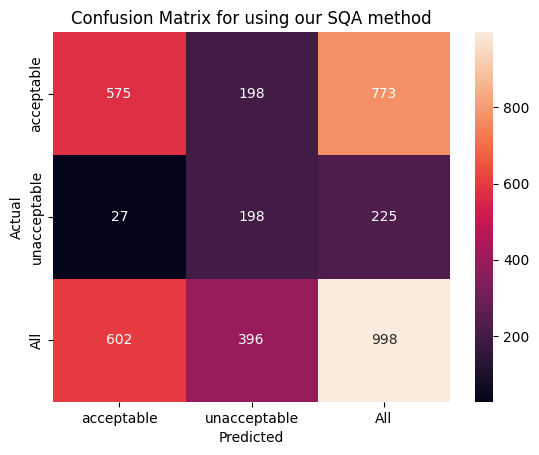

In [32]:
Y_SQA,Dataset_history,Lead_Dataset_SQA,X_SQA = Select_Stat_run("own",path_petastorm,Y_true,Y)

In [ ]:
Y_MoRE,Dataset_history_MoRE,Lead_Dataset_MoRE,X_MoRE = Select_Stat_run("MoRE",path_petastorm,Y_true,Y)

In [33]:
##ROC for our SQA : 
def ROC_SQA(path_peta,y_true,y,Threshold_tab,L_dataset,X_score):
    TPR = np.array([])
    FPR = np.array([])
    REC = np.array([])
    PREC = np.array([])
    ACC = np.array([])
    for j in Threshold_tab:
        matrix = {}
        matrix["Y_True"] = y_true
        Y_predicted = np.array([])
        for arr in L_dataset:
            prediction,_,_ = set_qualification_SQA(arr,ECG_lead,T = j)
            Y_predicted = np.append(Y_predicted,prediction)
        
        _,ind_sort = Sorter_X_array(X_score)
        Y_predicted = Y_predicted[ind_sort]
        Y_predicted = Y_predicted[y!="unlabeled"]
        matrix["Y_predict"] = Y_predicted
        cm = confusion_matrix(y_true, Y_predicted).ravel()
        if len(cm)>4:
            tp,fn,fp,tn = cm[cm!=0]
        else :
            tp,fn,fp,tn = cm
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        if tp+fp == 0:
            Prec = 0
        else : 
            Prec = tp/(tp+fp)
        Recall = tp/(tp+fn)

        acc = (tp+fn)/(tp+fn+fp+tn)
        #acc = 2*Prec*Recall/(Recall+Prec)
        TPR = np.append(TPR,tpr)
        FPR = np.append(FPR,fpr)
        REC = np.append(REC,Recall)
        PREC = np.append(PREC,Prec)
        ACC = np.append(ACC,acc)
    return TPR,FPR,REC,PREC,ACC

def ROC_MoRE(path_peta,y_true,y,Threshold_tab,L_dataset,X_score):
    TPR = np.array([])
    FPR = np.array([])
    REC = np.array([])
    PREC = np.array([])
    ACC= np.array([])
    for j in Threshold_tab:
        matrix = {}
        matrix["Y_True"] = y_true
        Y_predicted = np.array([])
        for arr in L_dataset:
            prediction,_ = set_qualification_MoRE(arr,ECG_lead,T = j)
            Y_predicted = np.append(Y_predicted,prediction)
        
        X_pred_sorted,ind_sort = Sorter_X_array(X_score)
        Y_predicted = Y_predicted[ind_sort]
        Y_predicted = Y_predicted[y!="unlabeled"]
        matrix["Y_predict"] = Y_predicted
        cm = confusion_matrix(y_true, Y_predicted).ravel()
        if len(cm)>4:
            tp,fn,fp,tn = cm[cm!=0]
        else :
            tp,fn,fp,tn = cm
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        if tp+fp == 0:
            Prec = 0
        else : 
            Prec = tp/(tp+fp)
        Recall = tp/(tp+fn)
        acc = (tp+tn)/(tp+tn+fp+fn)
        TPR = np.append(TPR,tpr)
        FPR = np.append(FPR,fpr)
        REC = np.append(REC,Recall)
        PREC = np.append(PREC,Prec)
        ACC = np.append(ACC,acc)
    return TPR,FPR,REC,PREC,ACC

def Choose_ROC(name_method,path_peta,y_true,y,Threshold_tab,L_dataset,X_score):
    if name_method == "own":
        return ROC_SQA(path_peta,y_true,y,Threshold_tab,L_dataset,X_score)
    elif name_method == "MoRE":
        return ROC_MoRE(path_peta,y_true,y,Threshold_tab,L_dataset,X_score)


1.879396984924623


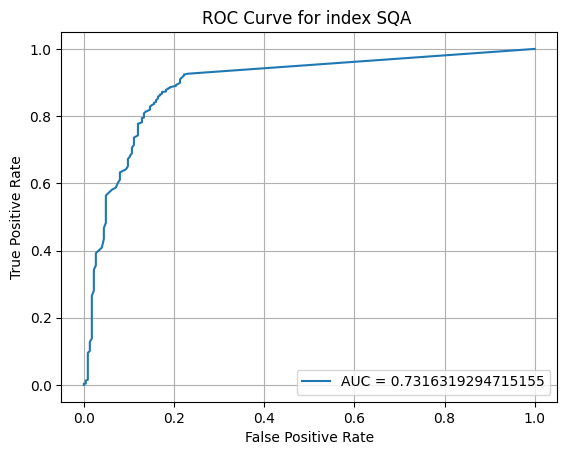

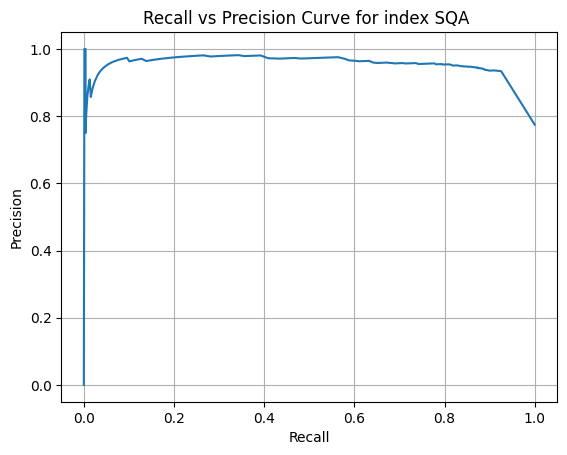

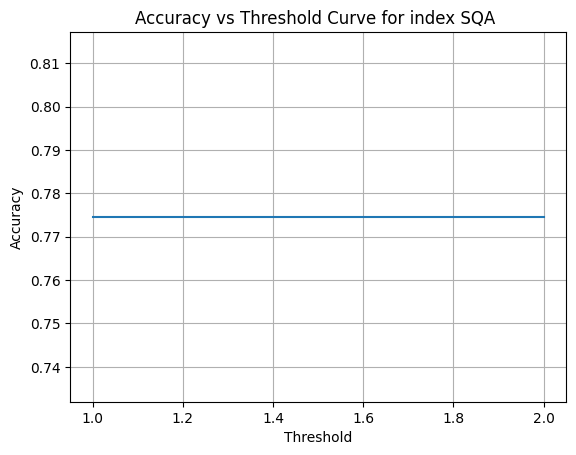

1.0


In [34]:
SQA_thresh = np.linspace(1,2,200)
TPR_SQA,FPR_SQA,REC_SQA,PREC_SQA,ACC_SQA = Choose_ROC("own",path_petastorm,Y_true,Y,SQA_thresh,Lead_Dataset_SQA,X_SQA)
ROC_plot(TPR_SQA,FPR_SQA,SQA_thresh,"SQA",1/200)
RP_plot(REC_SQA,PREC_SQA,SQA_thresh,"SQA",1/200)
ACC_Threshod_plot(ACC_SQA,SQA_thresh,"SQA")

In [ ]:
MoRE_thresh = np.linspace(0,4,200)
TPR_MoRE,FPR_MoRE,REC_MoRE,PREC_MoRE,ACC_MoRE = Choose_ROC("MoRE",path_petastorm,Y_true,Y,MoRE_thresh,Lead_Dataset_MoRE,X_MoRE)
ROC_plot(TPR_MoRE,FPR_MoRE,MoRE_thresh,"MoRE",1/200)
RP_plot(REC_MoRE,PREC_MoRE,MoRE_thresh,"MoRE",1/200)
ACC_Threshod_plot(ACC_MoRE,MoRE_thresh,"MoRE")

In [ ]:
##Comparison SQA :

plt.figure()
auc_SQA = np.abs(simpson(TPR_SQA,x=FPR_SQA,dx = FPR_SQA[1]-FPR_SQA[0]))
auc_MoRE = np.abs(simpson(TPR_MoRE,x=FPR_MoRE,dx = FPR_MoRE[1]-FPR_MoRE[0]))
plt.plot(FPR_SQA,TPR_SQA,"-r",label = "AUC = "+str(auc_SQA))
plt.plot(FPR_MoRE,TPR_MoRE,"-b",label = "AUC = "+str(auc_MoRE))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for index for both method tested ")
plt.legend(loc=4)
plt.grid()
plt.show()



In [ ]:
plt.figure()
    #auc_TSD = np.abs(simpson(TPR_TSD,x=FPR_TSD,dx = 1/(len(FPR_TSD))))
    #opt_thresh = Threshold[np.argmin(np.sqrt((1-true_PR)**2+(False_PR)**2))]
    #print(opt_thresh)
x = np.linspace(0,1,200)
auc_TSD = np.abs(simpson(TPR_TSD,x=FPR_TSD,dx = 1/(len(FPR_TSD))))
auc_M = np.abs(simpson(TPR_M,x=FPR_M,dx = 1/(len(FPR_M))))
auc_CC = np.abs(simpson(TPR_CC,x=FPR_CC,dx = 1/(len(FPR_CC))))
auc_wPMF = np.abs(simpson(TPR_wPMF,x=FPR_wPMF,dx = 1/(len(FPR_wPMF))))
auc_f = np.abs(simpson(TPR_f,x=FPR_f,dx = 1/(len(FPR_f))))
auc_SQA = np.abs(simpson(TPR_SQA,x=FPR_SQA,dx = 1/(len(FPR_SQA))))
plt.plot(FPR_TSD,TPR_TSD,label = "TSD : AUC = {:.2f}".format(auc_TSD) )
plt.plot(FPR_M,TPR_M,label = "Morphological : AUC = {:.2f}".format(auc_M))
plt.plot(FPR_CC,TPR_CC,label = "Correlation coef : AUC = {:.2f}".format(auc_CC))
plt.plot(FPR_wPMF,TPR_wPMF,label = "wPMF : AUC = {:.2f}".format(auc_wPMF))
plt.plot(FPR_f,TPR_f,label = "Flatline : AUC = {:.2f}".format(auc_f))
plt.plot(FPR_SQA,TPR_SQA,label = "SQA : AUC = {:.2f}".format(auc_SQA))
plt.plot(x,x,"--k",label = "Reference line")
    # for t,i,j in zip(Threshold,False_PR,true_PR):
    #     plt.annotate("{0:.2f}".format(t),xy = (i,j))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for all indexes created ")
plt.legend(loc=4)
plt.grid()
plt.show()